In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, output_channels, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, output_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [4]:
def dice_loss(pred, target, smooth=1e-6):
    
    #flattening predictions and targets
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    #computing intersection and union
    intersection = torch.sum(pred_flat * target_flat)
    union = torch.sum(pred_flat) + torch.sum(target_flat)
    
    #computing Dice Loss
    dice_loss = 1 - (2.0 * intersection + smooth) / (union + smooth)
    
    return dice_loss

In [5]:
def train_test_loop(model, num_epochs, train_loader, criterion, optimizer, device):
    #shifting the model to device
    model.to(device)
    Loss = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            #shifting the inputs and the labels to same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            #resetting the gradient values
            optimizer.zero_grad()

            #computing the model output for the datapoint
            outputs = model(inputs)
            #computing the loss
            loss = criterion(outputs, labels)

            #backpropagating the loss
            loss.backward()

            #updating the gradients
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        Loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return model, Loss

In [6]:
class BaseSemanticDataset(Dataset):

    def __init__(self, dataset_dir, transform, target_transform,
                 image_set='train',
                 img_suffix='.png',
                 ann_suffix='.png',
                 data_prefix = dict(img_path='img', ann_path='ann')):

        super(BaseSemanticDataset, self).__init__()
        self.transform = transform
        self.target_transform = transform
        # self.class_names = metainfo['class_names']
        self.img_path = os.path.join(dataset_dir, data_prefix['img_path'], image_set)
        self.ann_path = os.path.join(dataset_dir, data_prefix['ann_path'], image_set)
        print('img_folder_name: {img_folder_name}, ann_folder_name: {ann_folder_name}'.format(
            img_folder_name=self.img_path, ann_folder_name=self.ann_path))
        self.img_names = [img_name.split(img_suffix)[0] for img_name in os.listdir(self.img_path) if
                          img_name.endswith(img_suffix)]
        self.img_suffix = img_suffix
        self.ann_suffix = ann_suffix

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_names[index] + self.img_suffix))
        ann = Image.open(os.path.join(self.ann_path, self.img_names[index] + self.ann_suffix))
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            ann = self.target_transform(ann)
            
        ann = np.array(ann)

        return img, ann

    def __len__(self):
        return len(self.img_names)

In [7]:
transform = transforms.Compose([
                    transforms.Resize((512, 512)),
                    transforms.ToTensor(),
                ])

target_transform = transforms.Compose([
                    transforms.Resize((512, 512)),
                    transforms.ToTensor(),
                ])

dataset_dir = 'data/my_dataset'
train_dataset = BaseSemanticDataset(dataset_dir, transform, target_transform,
                 image_set='train',
                 img_suffix='.png',
                 ann_suffix='.png',
                 data_prefix= dict(img_path='img', ann_path='ann'))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = BaseSemanticDataset(dataset_dir, transform, target_transform,
                 image_set='val',
                 img_suffix='.png',
                 ann_suffix='.png',
                 data_prefix= dict(img_path='img', ann_path='ann'))

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

img_folder_name: data/my_dataset/img/train, ann_folder_name: data/my_dataset/ann/train
img_folder_name: data/my_dataset/img/val, ann_folder_name: data/my_dataset/ann/val


In [8]:
model = UNet(3, 2, 1)

#defining loss function and optimizer
criterion = dice_loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model1, loss1 = train_test_loop(model, num_epochs, train_loader, criterion, optimizer, device)

Epoch [1/100], Loss: -0.4736
Epoch [2/100], Loss: 1.2688
Epoch [3/100], Loss: -0.6242
Epoch [4/100], Loss: -0.6292
Epoch [5/100], Loss: -1.8112
Epoch [6/100], Loss: -7.8893
Epoch [7/100], Loss: 0.3939
Epoch [8/100], Loss: 1.2416
Epoch [9/100], Loss: 1.1184
Epoch [10/100], Loss: 0.9853
Epoch [11/100], Loss: 0.6642
Epoch [12/100], Loss: -0.2056
Epoch [13/100], Loss: 0.6536
Epoch [14/100], Loss: 1.7934
Epoch [15/100], Loss: 1.6161
Epoch [16/100], Loss: 1.4732
Epoch [17/100], Loss: 1.1543
Epoch [18/100], Loss: 0.4624
Epoch [19/100], Loss: 2.9492
Epoch [20/100], Loss: 1.0526
Epoch [21/100], Loss: 1.0302
Epoch [22/100], Loss: 1.0061
Epoch [23/100], Loss: 0.9917
Epoch [24/100], Loss: 0.9805
Epoch [25/100], Loss: 0.9688
Epoch [26/100], Loss: 0.9622
Epoch [27/100], Loss: 0.9559
Epoch [28/100], Loss: 0.9501
Epoch [29/100], Loss: 0.9441
Epoch [30/100], Loss: 0.9392
Epoch [31/100], Loss: 0.9337
Epoch [32/100], Loss: 0.9266
Epoch [33/100], Loss: 0.9215
Epoch [34/100], Loss: 0.9166
Epoch [35/100], L

In [9]:
torch.save(trained_model1.state_dict(), 'trained_model4.pth')

Text(0.5, 1.0, 'Masked Image')

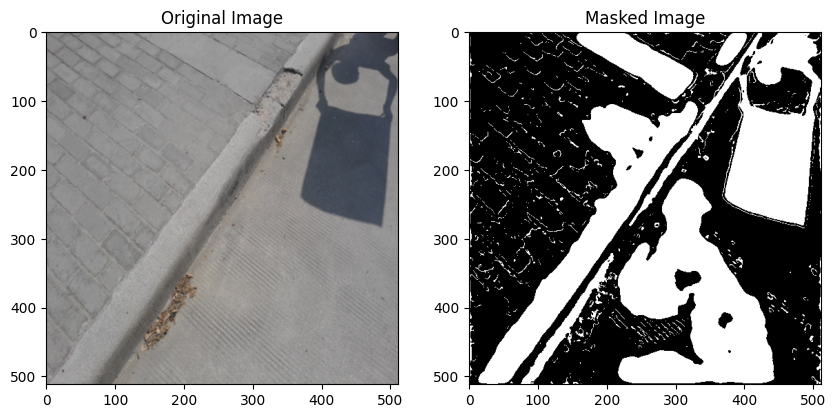

In [62]:
trained_model1.eval()
import matplotlib.pyplot as plt
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
output = 0
for inputs, label in test_loader:
    orig_image = np.transpose(inputs[0].cpu().detach().numpy(), (1, 2, 0))
    inputs, label = inputs.to(device), label.to(device)
    output = np.squeeze(trained_model1(inputs).cpu().detach().numpy(), axis=0)*255

    #binarizing the image
    thresh = 20
    output_mask = np.where(output > thresh, 255, 0)
    output_mask = output_mask.astype(np.uint8)

    #plotting the original image and the obtained mask
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_mask, cmap='gray')
    plt.title('Masked Image')
    break


In [65]:
trained_model1.eval()
running_loss = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    running_loss /= len(val_loader)

print(f"The test loss is: {running_loss:.4f}")

The test loss is: 0.9550
